In [2]:
# Import Packages 

import numpy as np
import scipy.interpolate
import scipy.optimize as opt
import copy as copy
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator as pchip

In [26]:
# Define Parameters

beta = 0.8
R = 1.02
alpha = 1/3

In [4]:
# Define Primitive Functions 

def u(c):
    return np.log(c)

def u_dash(c):
    return 1/c

def f(k):
    return k**alpha

def f_dash(k):
    return alpha*k**(alpha-1)


In [28]:
# Calculate optimal k 

def calculate_optimal_k(R, alpha): 
    return (R / alpha) ** (1 / (alpha - 1))

k_star = calculate_optimal_k(R, alpha)

In [20]:
# Functions to solve FOCs 

def threshold_FOC(w, phi, vprime):
    target = u_dash(w - (1-phi) * k_star) - beta * R * vprime((k_star **alpha) - R * phi * k_star) 
    return target 

def bonds_foc(b, w, phi, v_prime): ## FOC for unconstrained agent
    target_0 = u_dash(w - b - k_star) - beta * v_prime(f_dash(k_star) + R*b) * R
    return target_0

def capital_foc(k, w, phi, v_dash):
    target = u_dash(w - (1 - phi) * k) * (1 - phi) - beta * v_dash(f(k) - R * phi * k) * (f_dash(k) - R * phi)
    return target

def solve_for_bonds(w, phi, v_dash, initial_guess):
    b = opt.fsolve(bonds_foc, initial_guess, args = (w, phi, v_dash))
    return b

def solve_for_capital(w, phi, v_dash, initial_guess): 
    k = opt.fsolve(capital_foc, initial_guess, args = (w, phi, v_dash))
    return k


In [21]:
# Set up grid

w_grid = np.linspace(0.01, 5, 1000)

# Define initial guess for threshold value of w 

w_threshold = 1


In [24]:
# Process of value function iteration 

def vfi(phi): 

    k_star = calculate_optimal_k(R, alpha)

    # Initialize policy functions 

    b_policy = np.zeros(len(w_grid))
    k_policy = np.ones(len(w_grid))

    # Initialize value function

    v = np.log(w_grid)

    # Form a loop to iterate until we are below a specified tolerance

    tol = 1e-6

    error = 1

    while error > tol:

        # Form a cubic spline approximation to the value function 

        v_approx = pchip(w_grid, v)

        # Calculate derivative of v_approx

        v_approx_dash = v_approx.derivative(1)

        # Given v_approx_dash, calculate threshold value of w: 

        w_threshold = opt.fsolve(threshold_FOC, 1, args = (phi, v_approx_dash))

        k_guess = 0.01 
        b_guess = 0.01

        v_new = np.zeros(len(w_grid))

        for i in range(len(w_grid)):

            # Calculate policy functions for w < w_threshold, which corresponds to the constrained agent

            if w_grid[i] < w_threshold: 

                k_policy[i] = solve_for_capital(w_grid[i], phi, v_approx_dash, k_guess)
                b_policy[i] = - phi * k_policy[i]

                v_new[i] = u(w_grid[i] - (1 - phi) * k_policy[i]) + beta * v_approx(f(k_policy[i]) - R * phi * k_policy[i])

            else: 

                # Calculate policy functions for w >= w_threshold, which corresponds to the unconstrained agent

                b_policy[i] = solve_for_bonds(w_grid[i], phi, v_approx_dash, b_guess)
                k_policy[i] = k_star

                v_new[i] = u(w_grid[i] - b_policy[i] - k_star) + beta * v_approx(f_dash(k_star) + R * b_policy[i])

            # Update guess for k and b

            k_guess = k_policy[i]
            b_guess = b_policy[i]

            error = np.max(np.abs(v_new - v))

            v = copy.deepcopy(v_new)

    return v, b_policy, k_policy, w_threshold
        

In [33]:
v, b_policy, k_policy, w_thrshold = vfi(0.8)

C:\Users\tomru\AppData\Local\Temp\ipykernel_21260\4161084352.py:4: RuntimeWarning: invalid value encountered in log
  return np.log(c)


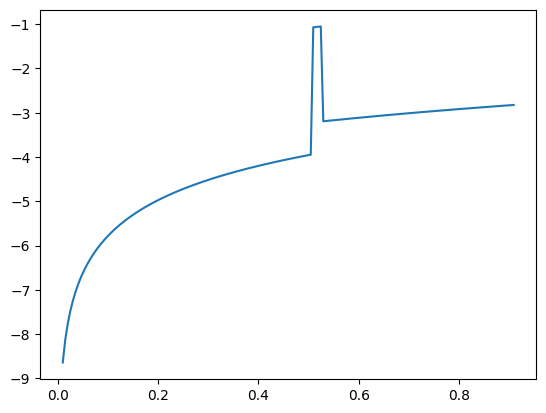

In [34]:
# Plot value function

plt.plot(w_grid, v)
plot(v)